<a href="https://colab.research.google.com/github/Tithimohanta/CNN_AI-ML/blob/main/210149_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Clone your GitHub repository (custom images + model folder)
!git clone https://github.com/Tithimohanta/CNN_AI-ML.git



Cloning into 'CNN_AI-ML'...
remote: Enumerating objects: 3268, done.
remote: Counting objects: 100% (3268/3268), done.
remote: Compressing objects: 100% (3265/3265), done.
remote: Total 3268 (delta 0), reused 3268 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3268/3268), 27.85 MiB | 33.28 MiB/s, done.


In [6]:
# Basic imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [5]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [7]:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)


In [8]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



In [9]:
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),   # 🔥 THIS FIXES THE ERROR
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



In [10]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)


100%|██████████| 170M/170M [00:02<00:00, 60.2MB/s]


In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = train_dataset.classes
print(classes)


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [13]:
model = CNN().to(device)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {epoch_loss:.4f}  Accuracy: {epoch_acc:.2f}%")


Epoch [1/20] Loss: 1.5724  Accuracy: 41.69%
Epoch [2/20] Loss: 1.2551  Accuracy: 54.99%
Epoch [3/20] Loss: 1.1270  Accuracy: 59.98%
Epoch [4/20] Loss: 1.0428  Accuracy: 63.47%
Epoch [5/20] Loss: 0.9770  Accuracy: 65.87%
Epoch [6/20] Loss: 0.9355  Accuracy: 67.41%
Epoch [7/20] Loss: 0.8919  Accuracy: 69.04%
Epoch [8/20] Loss: 0.8508  Accuracy: 70.61%
Epoch [9/20] Loss: 0.8290  Accuracy: 71.40%
Epoch [10/20] Loss: 0.8028  Accuracy: 72.78%
Epoch [11/20] Loss: 0.7734  Accuracy: 73.24%
Epoch [12/20] Loss: 0.7541  Accuracy: 74.34%
Epoch [13/20] Loss: 0.7322  Accuracy: 75.12%
Epoch [14/20] Loss: 0.7143  Accuracy: 75.66%
Epoch [15/20] Loss: 0.6969  Accuracy: 76.35%
Epoch [16/20] Loss: 0.6816  Accuracy: 76.86%
Epoch [17/20] Loss: 0.6650  Accuracy: 77.48%
Epoch [18/20] Loss: 0.6492  Accuracy: 77.95%
Epoch [19/20] Loss: 0.6391  Accuracy: 78.54%
Epoch [20/20] Loss: 0.6243  Accuracy: 78.95%


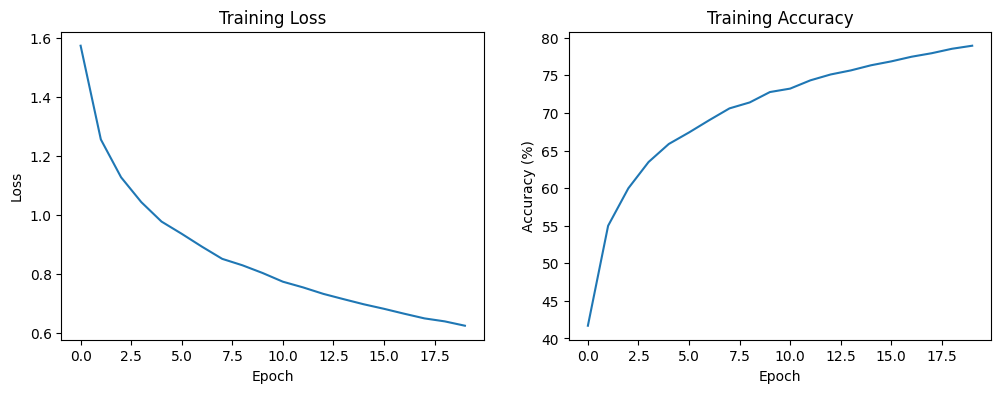

In [16]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.show()


In [17]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
print("Test Accuracy:", test_acc)


Test Accuracy: 81.33


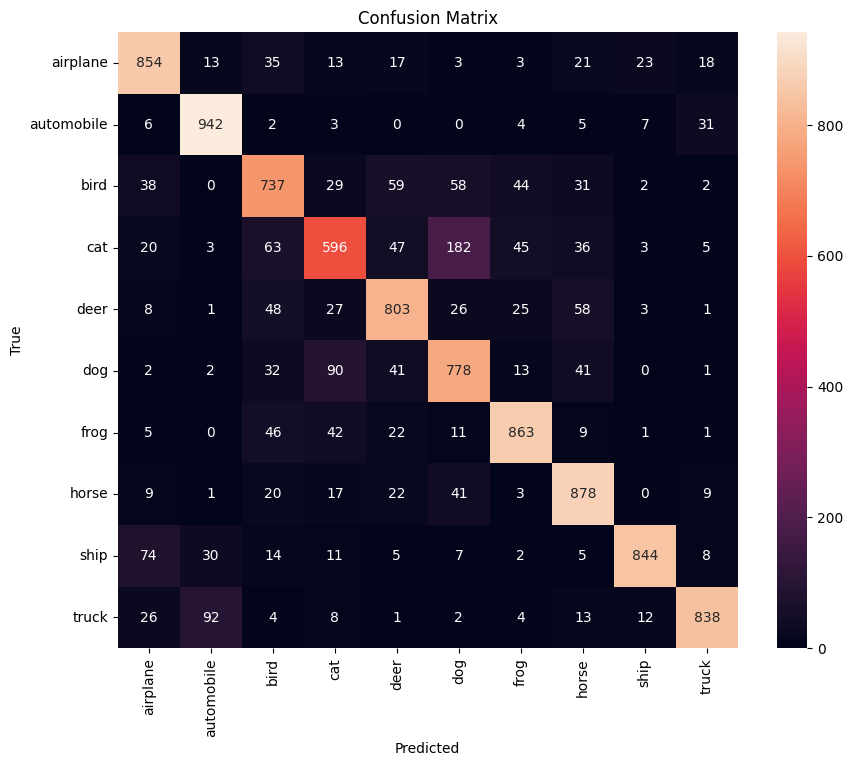

In [18]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [19]:
os.makedirs("CNN/model", exist_ok=True)
torch.save(model.state_dict(), "CNN/model/cifar10_cnn.pth")


In [20]:
image_dir = "CNN/Custom"   # phone images from GitHub

model.load_state_dict(torch.load("CNN/model/cifar10_cnn.pth", map_location=device))
model.eval()

def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)

    return classes[pred.item()], conf.item(), image


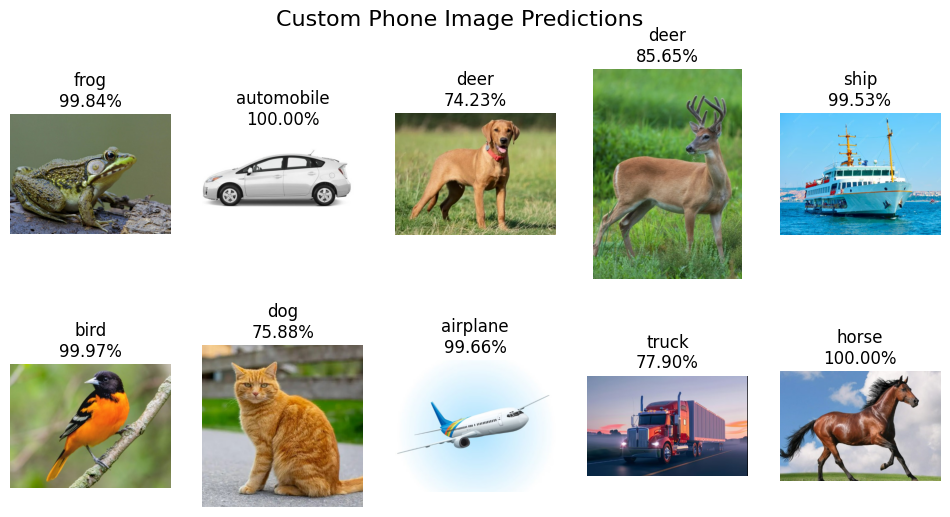

In [21]:
images = os.listdir(image_dir)

plt.figure(figsize=(12,6))

for i, img_name in enumerate(images):
    path = os.path.join(image_dir, img_name)
    label, conf, img = predict_image(path)

    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title(f"{label}\n{conf*100:.2f}%")
    plt.axis("off")

plt.suptitle("Custom Phone Image Predictions", fontsize=16)
plt.show()


In [22]:
wrong = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong.append((images[i], labels[i], preds[i]))
        if len(wrong) >= 3:
            break


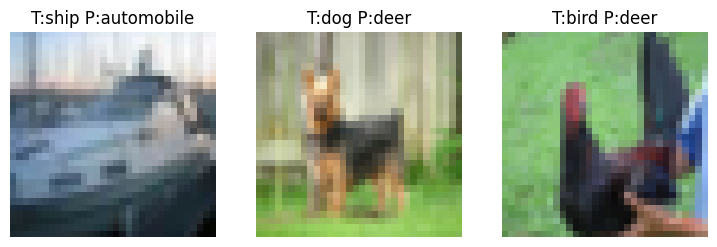

In [23]:
plt.figure(figsize=(9,3))

for i in range(3):
    img, true, pred = wrong[i]
    img = img.cpu().permute(1,2,0) * torch.tensor(std) + torch.tensor(mean)

    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.title(f"T:{classes[true]} P:{classes[pred]}")
    plt.axis("off")

plt.show()
